In [1]:
!pip install torch torchvision torchaudio
!pip install transformers scikit-learn

In [2]:
import torch
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
import pandas as pd
from transformers import DistilBertTokenizer, BertTokenizer
from torch.utils.data import DataLoader, TensorDataset
from transformers import DistilBertForSequenceClassification, BertForSequenceClassification
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, confusion_matrix, classification_report, precision_recall_fscore_support
import plotly.graph_objects as go
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import resample
import random
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

print("Is GPU available?", torch.cuda.is_available())
print("CUDA Device Count:", torch.cuda.device_count())
!nvidia-smi

Is GPU available? True
CUDA Device Count: 1
Sat Feb 15 18:52:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8             11W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+---

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd gdrive/MyDrive/PW_DEEP

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/PW_DEEP


Load data

In [4]:
df_train = pd.read_excel('train.xlsx')
df_val = pd.read_excel('val.xlsx')
df_test = pd.read_excel('test.xlsx')

Distribuzione delle etichette nel dataset di training:
 label
2    83.97
0     8.06
1     7.97
Name: proportion, dtype: float64

Distribuzione delle etichette nel dataset di validazione:
 label
2    83.97
0     8.06
1     7.97
Name: proportion, dtype: float64

Distribuzione delle etichette nel dataset di test:
 label
2    84.00
0     8.06
1     7.94
Name: proportion, dtype: float64


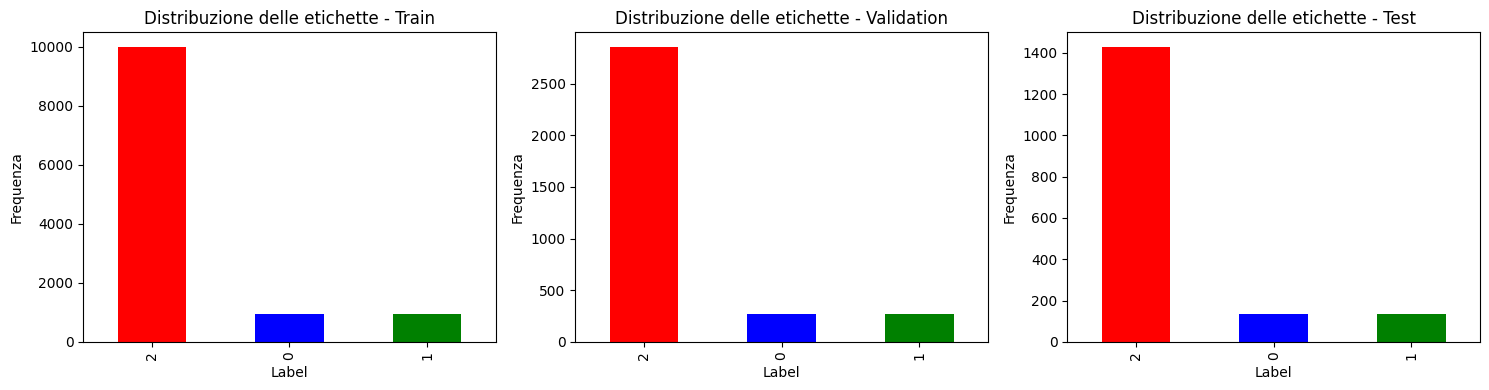

In [5]:
train_dist = round(df_train['label'].value_counts(normalize=True) * 100,2)
val_dist = round(df_val['label'].value_counts(normalize=True) * 100,2)
test_dist = round(df_test['label'].value_counts(normalize=True) * 100,2)
print("Distribuzione delle etichette nel dataset di training:\n", train_dist)
print("\nDistribuzione delle etichette nel dataset di validazione:\n", val_dist)
print("\nDistribuzione delle etichette nel dataset di test:\n", test_dist)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
datasets = {'Train': df_train, 'Validation': df_val, 'Test': df_test}
for ax, (name, df) in zip(axes, datasets.items()):
    df['label'].value_counts().plot(kind='bar', ax=ax, color=['red', 'blue', 'green'])
    ax.set_title(f"Distribuzione delle etichette - {name}")
    ax.set_xlabel("Label")
    ax.set_ylabel("Frequenza")
plt.tight_layout()
# plt.show()

## Upsampling, tutte le 3 classi a 3k

In [6]:
from sklearn.utils import resample
import pandas as pd
import random
N_SAMPLES = 3000

df_majority = df_train[df_train['label'] == 2].reset_index(drop=True)
df_minority_0 = df_train[df_train['label'] == 0].reset_index(drop=True)
df_minority_1 = df_train[df_train['label'] == 1].reset_index(drop=True)

# downsampling della majoritty
df_majority = df_majority.iloc[random.sample(list(df_majority.index), k=N_SAMPLES)].reset_index()

n = (N_SAMPLES // df_minority_0.shape[0])
df_minority_0 = pd.concat([df_minority_0] * n, ignore_index=True)
to_add = N_SAMPLES - df_minority_0.shape[0]
df_minority_0_to_add = df_minority_0.iloc[random.sample(list(df_minority_0.index), k=to_add)].reset_index(drop=True)
df_minority_0 = pd.concat([df_minority_0, df_minority_0_to_add])

n = (N_SAMPLES // df_minority_1.shape[0])
df_minority_1 = pd.concat([df_minority_1] * n, ignore_index=True)
to_add = N_SAMPLES - df_minority_1.shape[0]
df_minority_1_to_add = df_minority_1.iloc[random.sample(list(df_minority_1.index), k=to_add)].reset_index(drop=True)
df_minority_1 = pd.concat([df_minority_1, df_minority_1_to_add])

df_train = pd.concat([df_majority, df_minority_0, df_minority_1])
df_train.drop(columns=["index"], inplace=True)
df_train.to_excel('train_balanced.xlsx', index=False)
df_train

,wav_id,label,audio_path,duration,text
0,1_3956,2,../Dataset/all/1_3956.wav,3.250,good finish and sharp slots that grip the scr...
1,1_4127,2,../Dataset/all/1_4127.wav,2.020,so glad it includes a magnet.
2,1_1880,2,../Dataset/all/1_1880.wav,2.550,"using a normal calibre is fine, i suppose."
3,2_550,2,../Dataset/all/2_550.wav,3.470,high temperature required to print with this ...
4,2_1700,2,../Dataset/all/2_1700.wav,3.378,to have been called dark armor.
...,...,...,...,...,...
148,1_12138,1,../Dataset/all/1_12138.wav,2.080,we should have an msivity adjustment.
149,1_11009,1,../Dataset/all/1_11009.wav,2.450,not happy with lead connect port location.
150,1_9836,1,../Dataset/all/1_9836.wav,2.130,do what they're designed to do no more.
151,1_5683,1,../Dataset/all/1_5683.wav,2.230,not so great even in a quick fix.


Distribuzione delle etichette nel dataset di training:
 label
2    33.33
0    33.33
1    33.33
Name: proportion, dtype: float64

Distribuzione delle etichette nel dataset di validazione:
 label
2    83.97
0     8.06
1     7.97
Name: proportion, dtype: float64

Distribuzione delle etichette nel dataset di test:
 label
2    84.00
0     8.06
1     7.94
Name: proportion, dtype: float64


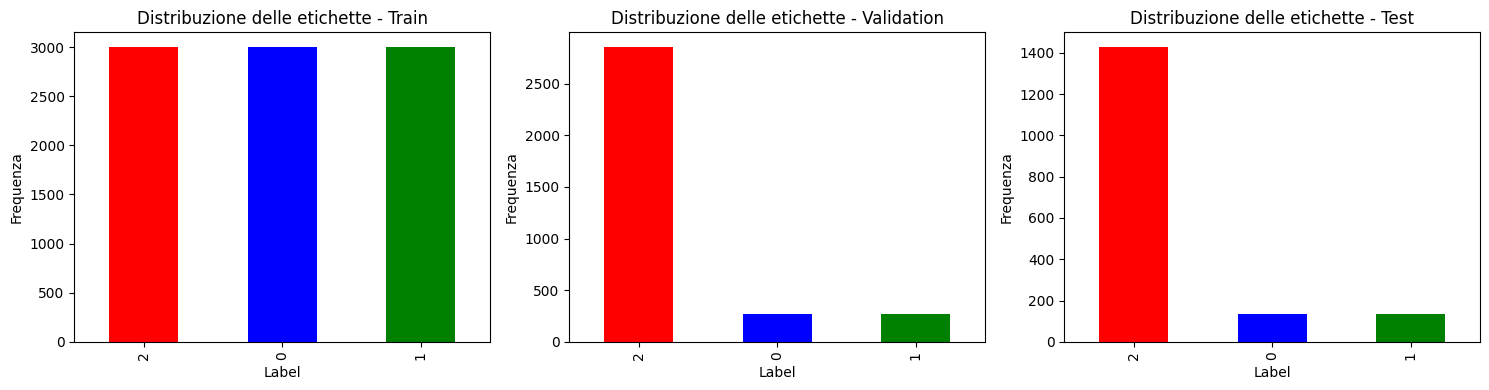

In [7]:
train_dist = round(df_train['label'].value_counts(normalize=True) * 100,2)
val_dist = round(df_val['label'].value_counts(normalize=True) * 100,2)
test_dist = round(df_test['label'].value_counts(normalize=True) * 100,2)
print("Distribuzione delle etichette nel dataset di training:\n", train_dist)
print("\nDistribuzione delle etichette nel dataset di validazione:\n", val_dist)
print("\nDistribuzione delle etichette nel dataset di test:\n", test_dist)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
datasets = {'Train': df_train, 'Validation': df_val, 'Test': df_test}
for ax, (name, df) in zip(axes, datasets.items()):
    df['label'].value_counts().plot(kind='bar', ax=ax, color=['red', 'blue', 'green'])
    ax.set_title(f"Distribuzione delle etichette - {name}")
    ax.set_xlabel("Label")
    ax.set_ylabel("Frequenza")
plt.tight_layout()
# plt.show()

## Extract only text and labels

In [8]:
X_train = df_train['text'].values
y_train = df_train['label'].values
X_val = df_val['text'].values
y_val = df_val['label'].values
X_test = df_test['text'].values
y_test = df_test['label'].values

print(X_train.shape, X_val.shape, X_test.shape)

(9000,) (3400,) (1700,)


In [9]:
# Replace non-string values with empty strings
X_train = [text if isinstance(text, str) else "" for text in X_train]
X_val = [text if isinstance(text, str) else "" for text in X_val]
X_test = [text if isinstance(text, str) else "" for text in X_test]

## Tokenizer

In [10]:
bert_model_name = 'distilbert-base-uncased'

tokenizer = DistilBertTokenizer.from_pretrained(bert_model_name)

def tokenize_texts(texts):
    return tokenizer(list(texts), padding=True, truncation=True, max_length=128, return_tensors="pt")

train_encodings = tokenize_texts(X_train)
val_encodings = tokenize_texts(X_val)
test_encodings = tokenize_texts(X_test)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Dataloader

In [11]:
# Create Tensor datasets
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(y_train))
val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], torch.tensor(y_val))
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], torch.tensor(y_test))

# Create DataLoader instances for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128)
test_dataloader = DataLoader(test_dataset, batch_size=128)

## Model
Load the bert model for sequence classification

In [12]:
model = DistilBertForSequenceClassification.from_pretrained(bert_model_name, num_labels=3)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


compute class weights for the dataset unbalance towards the positive label

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_weights_train = compute_class_weight(class_weight='balanced', classes=np.array([0, 1, 2]), y=y_train)
class_weights_train = torch.tensor(class_weights_train, dtype=torch.float).to(device)
print(f"Class weights train: {class_weights_train}")

class_weights_val = compute_class_weight(class_weight='balanced', classes=np.array([0, 1, 2]), y=y_val)
class_weights_val = torch.tensor(class_weights_val, dtype=torch.float).to(device)
print(f"Class weights val: {class_weights_val}")

# unique_classes, counts = torch.unique(torch.tensor(y_train), return_counts=True)
# class_weights = 1.0 / counts.float()  # Inverto le frequenze
# class_weights = class_weights / class_weights.sum()  # Normalizzo i pesi
# # class_weights = class_weights.to(self.device)  # Sposto sulla GPU se necessario
# print(f"Class weights: {class_weights}")

Class weights train: tensor([1., 1., 1.], device='cuda:0')
Class weights val: tensor([4.1363, 4.1820, 0.3970], device='cuda:0')


# Training

In [14]:
def save_best_checkpoint(model, optimizer, epoch, train_losses, val_losses, checkpoint_path="best_checkpoint.pth"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Best checkpoint saved at epoch {epoch}")

def load_checkpoint(model, optimizer, checkpoint_path="best_checkpoint.pth"):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    print(f"Checkpoint loaded from epoch {epoch}")
    return epoch, train_losses, val_losses

In [15]:
def fix_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [16]:
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

!nvidia-smi

Sat Feb 15 18:53:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P0             28W /   70W |     120MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [17]:
EPOCHS = 15
optimizer = AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
loss_train = CrossEntropyLoss()
loss_val = CrossEntropyLoss(weight=class_weights_val)

In [31]:
def train_and_validate(model, train_dataloader, val_dataloader, optimizer, epochs=3, checkpoint_path="best_checkpoint.pth", patience=3, seed=42):
    fix_seed(seed)
    train_losses = []    # Average training loss per epoch
    val_losses = []      # Average validation loss per epoch
    best_val_loss = float('inf')  # Set an initial best validation loss to infinity
    start_epoch = 0
    patience_counter = 0          # Counter to track the number of epochs without improvement

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print(f"Using device: {device}")
    try:
        # Check if checkpoint exists
        start_epoch, train_losses, val_losses = load_checkpoint(model, optimizer, checkpoint_path)
        best_val_loss = min(val_losses)  # Set the best_val_loss to the minimum of previous losses
    except FileNotFoundError:
        print("No checkpoint found, starting training from scratch.")

    for epoch in range(start_epoch, epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        model.train()

        # Collects all losses for the epoch
        train_loss_each_step = []
        for batch in train_dataloader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            optimizer.zero_grad()
            loss = loss_train(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            train_loss_each_step.append(loss.item())

        # Epoch Training Loss
        avg_train_loss_1epoch = sum(train_loss_each_step) / len(train_loss_each_step)
        train_losses.append(avg_train_loss_1epoch)

        # Validation Phase
        print("..Validation phase..")
        model.eval()
        val_loss_each_step = []
        with torch.no_grad():
            for batch in val_dataloader:
                input_ids, attention_mask, labels = [b.to(device) for b in batch]
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                val_loss = loss_train(outputs.logits, labels)
                val_loss_each_step.append(val_loss.item())

        # Epoch Validation Loss
        avg_val_loss_1epoch = sum(val_loss_each_step) / len(val_loss_each_step)
        val_losses.append(avg_val_loss_1epoch)
        # scheduler.step(avg_val_loss_1epoch)  # Adjust LR based on validation loss
        print(f"---> End of Epoch {epoch + 1} - Training Loss: {avg_train_loss_1epoch:.4f} - Validation Loss: {avg_val_loss_1epoch:.4f}\n")

        # Save the best checkpoint based on validation loss
        if avg_val_loss_1epoch < best_val_loss:
            print(f"\tValidation loss improved from {best_val_loss:.4f} to {avg_val_loss_1epoch:.4f}. Best model so far! (Saving checkpoint...)\n")
            best_val_loss = avg_val_loss_1epoch
            # save_best_checkpoint(model, optimizer, epoch + 1, train_losses, val_losses, checkpoint_path)
            patience_counter = 0
        else:
            patience_counter += 1

        # Early stopping if validation loss doesn't improve after a certain number of epochs (patience)
        if patience_counter >= patience:
            print(f"Validation loss hasn't improved for {patience} epochs. Stopping early at epoch {epoch + 1}.")
            break

    return train_losses, val_losses

In [32]:
train_losses, val_losses = train_and_validate(model, train_dataloader, val_dataloader, optimizer, epochs=EPOCHS, seed=42)

Using device: cuda
No checkpoint found, starting training from scratch.
Epoch 1/15


<ipython-input-14-e9fb820aa1ef>:13: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



..Validation phase..
---> End of Epoch 1 - Training Loss: 0.0299 - Validation Loss: 1.0137

	Validation loss improved from inf to 1.0137. Best model so far! (Saving checkpoint...)

Epoch 2/15
..Validation phase..
---> End of Epoch 2 - Training Loss: 0.0123 - Validation Loss: 1.0721

Epoch 3/15
..Validation phase..
---> End of Epoch 3 - Training Loss: 0.0207 - Validation Loss: 1.2539

Epoch 4/15
..Validation phase..
---> End of Epoch 4 - Training Loss: 0.0336 - Validation Loss: 0.9876

	Validation loss improved from 1.0137 to 0.9876. Best model so far! (Saving checkpoint...)

Epoch 5/15
..Validation phase..
---> End of Epoch 5 - Training Loss: 0.0237 - Validation Loss: 1.1783

Epoch 6/15
..Validation phase..
---> End of Epoch 6 - Training Loss: 0.0212 - Validation Loss: 1.2295

Epoch 7/15
..Validation phase..
---> End of Epoch 7 - Training Loss: 0.0324 - Validation Loss: 1.2170

Validation loss hasn't improved for 3 epochs. Stopping early at epoch 7.


In [33]:
def plot_epoch_losses(epoch_train_losses, epoch_val_losses):
    # Create a subplot layout for the epoch losses
    fig = make_subplots(
        rows=1, cols=1,
        subplot_titles=("Epoch-wise Losses"),
    )
    fig.add_trace(
        go.Scatter(x=list(range(1, len(epoch_train_losses) + 1)), y=epoch_train_losses,
                   mode='lines+markers', name='Train Loss (per epoch)', line=dict(color='green')),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(x=list(range(1, len(epoch_val_losses) + 1)), y=epoch_val_losses,
                   mode='lines+markers', name='Validation Loss (per epoch)', line=dict(color='orange')),
        row=1, col=1
    )
    fig.update_layout(
        title="Epoch-wise Training and Validation Losses",
        xaxis_title="Epochs",
        yaxis_title="Loss",
        template="plotly_white",
        legend=dict(x=0.5, y=-0.2, orientation="h", xanchor="center"),
        height=500,
        width=800
    )
    fig.show()

In [34]:
plot_epoch_losses(train_losses, val_losses)

In [35]:
# Evaluation
def evaluate(model, dataloader):
    model.eval()
    y_pred, y_true = [], []
    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits if hasattr(outputs, 'logits') else outputs[0]
            predictions = torch.argmax(logits, axis=1)
            y_pred.extend(predictions.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    return y_true, y_pred

def compute_metrics(y_true, y_pred, dataset_name):
    labels = ["Negative", "Neutral", "Positive"]
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=[0, 1, 2], zero_division=0)
    accuracy_all = accuracy_score(y_true, y_pred)
    recall_all = recall_score(y_true, y_pred, average='weighted', zero_division=1)
    precision_all = precision_score(y_true, y_pred, average='weighted', zero_division=1)
    f1_all = f1_score(y_true, y_pred, average='weighted', zero_division=1)

    print(f"\nMetrics for {dataset_name} Dataset:")
    for i, label in enumerate(labels):
        print(f"\nLabel: {label}")
        print(f"Precision: {precision[i]:.4f}")
        print(f"Recall:    {recall[i]:.4f}")
        print(f"F1-score:  {f1[i]:.4f}")
    print(f"\nOverall f1: {f1_all:.4f}, Accuracy: {accuracy_all:.4f}, precision: {precision_all:.4f}, recall: {recall_all:.4f}")


In [36]:
y_true_val, y_pred_val = evaluate(model, val_dataloader)
y_true_test, y_pred_test = evaluate(model, test_dataloader)

compute_metrics(y_true_val, y_pred_val, "Validation")
print()
compute_metrics(y_true_test, y_pred_test, "Test")


Metrics for Validation Dataset:

Label: Negative
Precision: 0.3125
Recall:    0.6934
F1-score:  0.4308

Label: Neutral
Precision: 0.2500
Recall:    0.2989
F1-score:  0.2723

Label: Positive
Precision: 0.9368
Recall:    0.8098
F1-score:  0.8687

Overall f1: 0.7859, Accuracy: 0.7597, precision: 0.8317, recall: 0.7597


Metrics for Test Dataset:

Label: Negative
Precision: 0.3593
Recall:    0.7737
F1-score:  0.4907

Label: Neutral
Precision: 0.3176
Recall:    0.3481
F1-score:  0.3322

Label: Positive
Precision: 0.9419
Recall:    0.8291
F1-score:  0.8819

Overall f1: 0.8068, Accuracy: 0.7865, precision: 0.8454, recall: 0.7865


In [28]:
from sklearn.metrics import confusion_matrix
import plotly.graph_objects as go
import numpy as np

def plot_confusion_matrix(y_true, y_pred, dataset_name):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])  # For classes 0, 1, 2
    labels = ["Negative", "Neutral", "Positive"]

    fig = go.Figure(data=go.Heatmap(
        z=cm,
        x=labels,  # Predicted labels
        y=labels,  # True labels
        colorscale='Blues',
        showscale=True,
        hoverongaps=False,
        text=cm,  # Annotate with the counts
        texttemplate="%{text}"
    ))
    fig.update_layout(
        title=f"Confusion Matrix - {dataset_name}",
        xaxis_title="Predicted Label",
        yaxis_title="True Label",
        xaxis=dict(tickmode='array', tickvals=list(range(3)), ticktext=labels),
        yaxis=dict(tickmode='array', tickvals=list(range(3)), ticktext=labels),
        autosize=False,
        width=500,
        height=500
    )
    fig.show()

plot_confusion_matrix(y_true_test, y_pred_test, "Test")

 Inference

In [42]:
def predict_sentiment(texts):
    encodings = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
    input_ids, attention_mask = encodings['input_ids'].to(device), encodings['attention_mask'].to(device)

    model.eval()
    with torch.no_grad():
        logits = model(input_ids, attention_mask=attention_mask).logits
        predictions = torch.argmax(logits, axis=1).cpu().numpy()

    return predictions

# Example inference
texts = ["I love this!", "This is terrible.", "i am not sure, maybe it's good"]
print(predict_sentiment(texts))

[2 0 1]
